In [2]:
import fastf1 as ff1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from fastf1 import plotting

In [3]:
# Setting up cache for ff1
ff1.Cache.clear_cache('./cache')
ff1.Cache.enable_cache('./cache')

In [4]:
SESSION_TYPES = [
	'FP1', # Treino livre 1
	'FP2', # TReino livre 2
	'FP3', # Treino livre 3
	'SQ', # Qualificatória da Sprint
	'Sprint', # Sprint...
	'Q', # Qualificatória
	'R', # Corrida
]

In [5]:
SESSION_NAME = 'R'
TRACK_NAME = 'Monza'
RACE_YEAR = 2024

In [6]:
session = ff1.get_session(RACE_YEAR, TRACK_NAME, SESSION_NAME)
session.load()
circuit_info = session.get_circuit_info()
session, circuit_info

core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

(2024 Season Round 16: Italian Grand Prix - Race,
 CircuitInfo(corners=               X             Y  Number Letter       Angle     Distance
 0    -569.580505   8153.724609       1         153.787332   873.817310
 1    -146.754578   8474.981445       2         -13.835843   933.178109
 2     611.600159  13310.620117       3         133.028518  1456.715654
 3    6808.655273  14630.753906       4         -54.042256  2082.063586
 4    7130.872070  15023.123047       5         121.752858  2141.208228
 5   10554.856445  15713.804688       6          54.641655  2496.912839
 6   10972.642578  12648.357422       7         -29.053283  2810.268922
 7    2562.920166   6171.023438       8         163.072861  3870.414732
 8    2478.041504   5270.562012       9         -21.066696  3972.575114
 9    1890.108276   4451.185547      10         152.544441  4074.890842
 10    -55.330734  -5800.166992      11         -95.852854  5154.703358, marshal_lights=               X             Y  Number Letter     

In [7]:
session.event

RoundNumber                                                   16
Country                                                    Italy
Location                                                   Monza
OfficialEventName    FORMULA 1 PIRELLI GRAN PREMIO D’ITALIA 2024
EventDate                                    2024-09-01 00:00:00
EventName                                     Italian Grand Prix
EventFormat                                         conventional
Session1                                              Practice 1
Session1Date                           2024-08-30 13:30:00+02:00
Session1DateUtc                              2024-08-30 11:30:00
Session2                                              Practice 2
Session2Date                           2024-08-30 17:00:00+02:00
Session2DateUtc                              2024-08-30 15:00:00
Session3                                              Practice 3
Session3Date                           2024-08-31 12:30:00+02:00
Session3DateUtc          

In [8]:
fastest_lap = session.laps.pick_fastest()
pos = fastest_lap.get_pos_data()
pos

,Date,Status,X,Y,Z,Source,Time,SessionTime
0,2024-09-01 14:17:00.230,OnTrack,-1369,-622,1872,pos,0 days 00:00:00.077000,0 days 02:09:16.311000
1,2024-09-01 14:17:00.670,OnTrack,-1340,-284,1873,pos,0 days 00:00:00.517000,0 days 02:09:16.751000
2,2024-09-01 14:17:00.850,OnTrack,-1317,-34,1874,pos,0 days 00:00:00.697000,0 days 02:09:16.931000
3,2024-09-01 14:17:01.190,OnTrack,-1298,181,1876,pos,0 days 00:00:01.037000,0 days 02:09:17.271000
4,2024-09-01 14:17:01.410,OnTrack,-1281,380,1877,pos,0 days 00:00:01.257000,0 days 02:09:17.491000
...,...,...,...,...,...,...,...,...
313,2024-09-01 14:18:20.250,OnTrack,-1456,-1809,1866,pos,0 days 00:01:20.097000,0 days 02:10:36.331000
314,2024-09-01 14:18:20.630,OnTrack,-1443,-1602,1868,pos,0 days 00:01:20.477000,0 days 02:10:36.711000
315,2024-09-01 14:18:20.990,OnTrack,-1411,-1145,1870,pos,0 days 00:01:20.837000,0 days 02:10:37.071000
316,2024-09-01 14:18:21.270,OnTrack,-1399,-988,1870,pos,0 days 00:01:21.117000,0 days 02:10:37.351000


In [9]:
def rotate(xy, *, angle):
	rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
	return np.matmul(xy, rot_mat)

In [10]:
track = pos.loc[:, ('X', 'Y')].to_numpy()

track_ang = circuit_info.rotation / 180 * np.pi

rotated_track = rotate(track, angle=track_ang)


In [11]:
marshal_zone = circuit_info.marshal_sectors
marshal_zone

,X,Y,Number,Letter,Angle,Distance
0,-1414.551025,-1183.938721,1,,176.267882,5672.670300
1,-1004.797058,3590.034912,2,,175.389327,415.774552
2,-746.148804,6605.345703,3,,175.342540,742.924487
3,-361.363373,9550.834961,4,,11.639333,1046.561587
4,-236.686249,11925.509766,5,,163.231074,1283.324155
5,1260.103516,13778.841797,6,,119.932378,1521.149358
6,5188.290039,14459.211914,7,,-87.922240,1925.073182
7,8780.698242,15508.452148,8,,111.627499,2308.291463
8,11051.104492,13374.690430,9,,4.955850,2745.998586
9,9169.135742,11564.648438,10,,119.805396,3030.289628


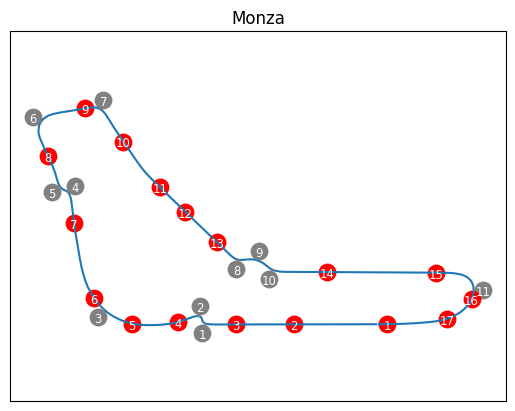

In [12]:
plt.plot(rotated_track[:, 0], rotated_track[:, 1])
offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
	# Create a string from corner number and letter
	txt = f"{corner['Number']}{corner['Letter']}"

	# Convert the angle from degrees to radian.
	offset_angle = corner['Angle'] / 180 * np.pi

	# Rotate the offset vector so that it points sideways from the track.
	offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

	# Add the offset to the position of the corner
	text_x = corner['X'] + offset_x
	text_y = corner['Y'] + offset_y

	# Rotate the text position equivalently to the rest of the track map
	text_x, text_y = rotate([text_x, text_y], angle=track_ang)

	# Rotate the center of the corner equivalently to the rest of the track map
	track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_ang)

	# Draw a circle next to the track.
	plt.scatter(text_x, text_y, color='grey', s=140)

	# Draw a line from the track to this circle.
	plt.plot([track_x, text_x], [track_y, text_y], color='grey')

	# Finally, print the corner number inside the circle.
	plt.text(text_x, text_y, txt, va='center_baseline', ha='center', size='small', color='white')

for _, zone in marshal_zone.iterrows():
	# Rotate the center of the corner equivalently to the rest of the track map
	track_x, track_y = rotate([zone['X'], zone['Y']], angle=track_ang)

	# Draw a circle next to the track.
	plt.scatter(track_x, track_y, color='red', s=140)

	# Finally, print the corner number inside the circle.
	plt.text(track_x, track_y, zone['Number'], va='center_baseline', ha='center', size='small', color='white')

plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()

In [13]:
# Getting the telemetry data
telemetry = fastest_lap.get_car_data()
# racer = fastest_lap.get_driver()
telemetry

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime
0,2024-09-01 14:17:00.435,11348,321,8,99,False,0,car,0 days 00:00:00.282000,0 days 02:09:16.516000
1,2024-09-01 14:17:00.595,11390,321,8,99,False,0,car,0 days 00:00:00.442000,0 days 02:09:16.676000
2,2024-09-01 14:17:00.835,11397,323,8,100,False,0,car,0 days 00:00:00.682000,0 days 02:09:16.916000
3,2024-09-01 14:17:01.115,11488,325,8,99,False,0,car,0 days 00:00:00.962000,0 days 02:09:17.196000
4,2024-09-01 14:17:01.395,11516,326,8,99,False,0,car,0 days 00:00:01.242000,0 days 02:09:17.476000
...,...,...,...,...,...,...,...,...,...,...
302,2024-09-01 14:18:20.475,11017,312,8,100,False,0,car,0 days 00:01:20.322000,0 days 02:10:36.556000
303,2024-09-01 14:18:20.675,11089,313,8,99,False,0,car,0 days 00:01:20.522000,0 days 02:10:36.756000
304,2024-09-01 14:18:20.915,11149,315,8,100,False,0,car,0 days 00:01:20.762000,0 days 02:10:36.996000
305,2024-09-01 14:18:21.195,11118,316,8,100,False,0,car,0 days 00:01:21.042000,0 days 02:10:37.276000


In [14]:
test = session.weather_data
test

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:26.141000,33.2,38.0,993.8,False,52.1,318,0.7
1,0 days 00:01:26.139000,33.2,37.0,993.9,False,52.1,207,1.0
2,0 days 00:02:26.141000,33.2,37.0,993.9,False,52.8,230,1.3
3,0 days 00:03:26.146000,33.2,36.0,993.8,False,52.8,200,0.7
4,0 days 00:04:26.151000,33.3,36.0,993.8,False,52.8,182,0.8
...,...,...,...,...,...,...,...,...
128,0 days 02:08:26.615000,32.2,33.0,992.7,False,43.9,213,1.4
129,0 days 02:09:26.629000,32.2,32.0,992.9,False,43.8,207,1.7
130,0 days 02:10:26.648000,32.2,32.0,992.8,False,43.8,218,1.8
131,0 days 02:11:26.663000,32.2,32.0,992.7,False,43.6,220,1.6


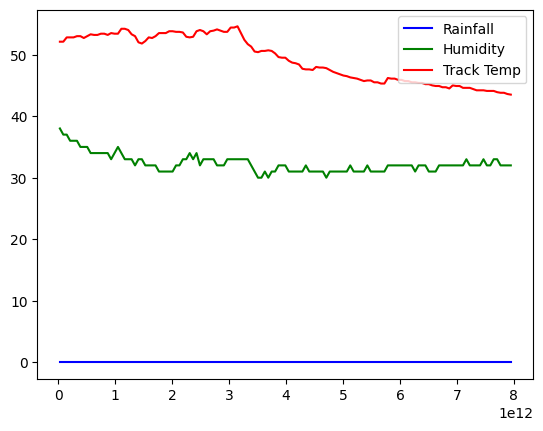

In [15]:
plt.plot(test['Time'], test['Rainfall']*50, color='blue', label='Rainfall')
plt.plot(test['Time'], test['Humidity'], color='green', label='Humidity')
plt.plot(test['Time'], test['TrackTemp'], color='red', label='Track Temp')
plt.legend()
plt.show()

In [16]:
drivers = []
for driver in session.drivers:
	drv = session.get_driver(driver)
	drivers.append(drv)

drivers = pd.DataFrame(drivers)
drivers = drivers.drop(['BroadcastName', 'DriverId', 'TeamId', 'FullName', 'HeadshotUrl', 'CountryCode', 'Q1', 'Q2', 'Q3'], axis=True)
drivers

,DriverNumber,Abbreviation,TeamName,TeamColor,FirstName,LastName,Position,ClassifiedPosition,GridPosition,Time,Status,Points
16,16,LEC,Ferrari,E80020,Charles,Leclerc,1.0,1,4.0,0 days 01:14:40.727000,Finished,25.0
81,81,PIA,McLaren,FF8000,Oscar,Piastri,2.0,2,2.0,0 days 00:00:02.664000,Finished,18.0
4,4,NOR,McLaren,FF8000,Lando,Norris,3.0,3,1.0,0 days 00:00:06.153000,Finished,16.0
55,55,SAI,Ferrari,E80020,Carlos,Sainz,4.0,4,5.0,0 days 00:00:15.621000,Finished,12.0
44,44,HAM,Mercedes,27F4D2,Lewis,Hamilton,5.0,5,6.0,0 days 00:00:22.820000,Finished,10.0
1,1,VER,Red Bull Racing,3671C6,Max,Verstappen,6.0,6,7.0,0 days 00:00:37.932000,Finished,8.0
63,63,RUS,Mercedes,27F4D2,George,Russell,7.0,7,3.0,0 days 00:00:39.715000,Finished,6.0
11,11,PER,Red Bull Racing,3671C6,Sergio,Perez,8.0,8,8.0,0 days 00:00:54.148000,Finished,4.0
23,23,ALB,Williams,64C4FF,Alexander,Albon,9.0,9,9.0,0 days 00:01:07.456000,Finished,2.0
20,20,MAG,Haas F1 Team,B6BABD,Kevin,Magnussen,10.0,10,13.0,0 days 00:01:08.302000,Finished,1.0


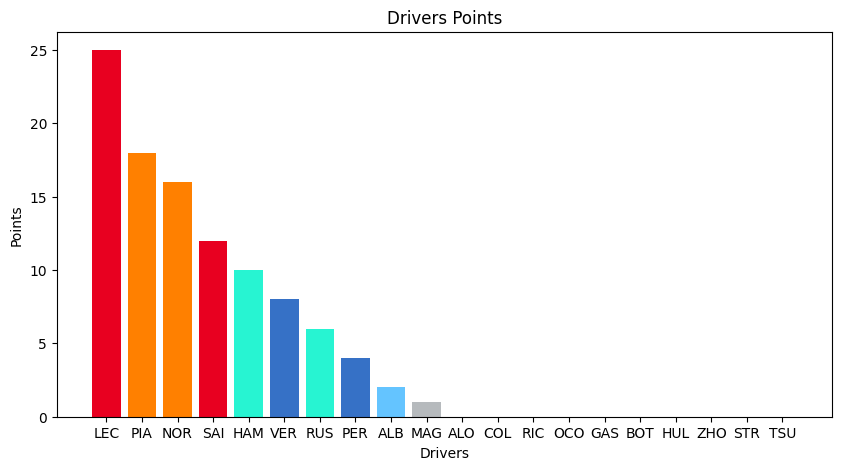

In [17]:
# Making a bar plot with the drivers
plt.figure(figsize=(10, 5))
plt.bar(drivers['Abbreviation'], drivers['Points'], color=[f"#{color}" for color in drivers['TeamColor']])
plt.title('Drivers Points')
plt.xlabel('Drivers')
plt.ylabel('Points')
plt.show()

In [18]:
START_YEAR_LOG = 2018

registry = {}

In [24]:
class Event:
	def __init__(self, year):
		self.year = year
		self.schedule = ff1.get_event_schedule(year)
		self.num_races = self.schedule['Location'].count()

	def getSchedule(self):
		return self.schedule

	def __str__(self):
		return self.schedule

	def getRace(self, weekend):
		return self.schedule[self.schedule['RoundNumber'] == weekend]

	def getNumRaces(self):
		return self.num_races

class RaceData:
	def __init__(self, race_data):
		self.data = race_data

	def getDriver(self, num):
		race = self.data
		racer = race.get_driver(num)
		return racer

	def getFastestLap(self):
		return self.data.laps.pick_fastest()

	def getAllDrivers(self):
		return self.data.drivers